# TM10007 Assignment template -- ECG data

### Importing modules

In [8]:

! pip install sklearn numpy matplotlib imbalanced-learn statsmodels

import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
import warnings
import statistics

from sklearn.compose import TransformedTargetRegressor
from scipy.stats import shapiro, lognorm, randint
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, KFold, train_test_split, RandomizedSearchCV, validation_curve #, multipletests
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn import datasets as ds, model_selection, metrics, neighbors
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
from sklearn.exceptions import ConvergenceWarning

# Classifiers
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


## Preprocessing

### Importing our data

In [9]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

### Exploring our data

In [10]:
# split labels from data
X = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# X = X.iloc[:50, :1000]
# y = y.iloc[:50]

print(X.shape)
print(y.shape)

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y) 
total_normal_ECG = y.size -np.count_nonzero(y) 
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100

print(f'{total_abnormal_ECG} people have an abnormal ECG')
print(f'{total_normal_ECG} people have a normal ECG')
print(f'The percentage of abnormal ECGs in this dataset is {percentage_abnormal} %')

(827, 9000)
(827,)
146 people have an abnormal ECG
681 people have a normal ECG
The percentage of abnormal ECGs in this dataset is 17.654171704957676 %


### Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [11]:
def missing_data(X_train):
    # Missing data
    X_train = X_train.replace(0, np.nan)  # make all zeros to NaN
    nan_count = X_train.isna().sum().sum()  # count missing data -> 10500 in our dataset

    # Delete missing data when > --% of feature of sample is missing
    X_train = X_train.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
    X_train = X_train.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

    # Missing data to median per feature
    for column in X_train.columns:
        X_train[column].fillna(X_train[column].median(), inplace=True)
    return X_train

### Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [12]:
def removing_outliers(X_train):
    # supress performance warning
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

    # Outliers: Tukey's fence 
    k=3
    fences=pd.DataFrame()
    outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

    for col in X_train.columns:
        q1, q3 = np.percentile(X_train[col], [25, 75])
        iqr = q3 - q1
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        fences[col]=[lower_fence, upper_fence]
        for row in X_train.index:
            if X_train.loc[row, col] < lower_fence or X_train.loc[row, col] > upper_fence:
                outliers.loc[row, col] = True # mark the place as an outlier

    row_count = (outliers == True).sum(axis=1)
    col_count = (outliers == True).sum(axis=0)
    total_count = row_count.sum() + col_count.sum()
    print(f'The total number of outliers in dataset x is {total_count}')

    # create a copy of x to modify
    new_x = X_train.copy()

    #replace outliers with maximum or minimun interquartile range of x by column
    for col in outliers.columns:
        q3 = X_train.loc[outliers[col] == False, col].quantile(0.75) # 3rd quartile of column where outlier is False
        q1 = X_train.loc[outliers[col] == False, col].quantile(0.25) # 1st quartile of column where outlier is False
        iqr = q3 - q1 # interquartile range of column where outlier is False
        lower_fence = q1 - k*iqr
        upper_fence = q3 + k*iqr
        new_x.loc[outliers[col] & (new_x[col] > upper_fence), col] = upper_fence # replace outliers with upper fence
        new_x.loc[outliers[col] & (new_x[col] < lower_fence), col] = lower_fence # replace outliers with lower fence

        X_train = new_x.copy()
    return X_train

### PIPELINE 1
- RobustScaler --> PCA + univariate --> Gaussian Naive Bayes

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1a = best_hp_1a.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
shape of X_train after pca (1020, 8)
size of features selected(4,)
after feature selection: (1020, 4)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1a = best_hp_1a.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_train after pca (1022, 7)
size of features selected(6,)
after feature selection: (1022, 6)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1a = best_hp_1a.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_train after pca (1022, 7)
size of features selected(3,)
after feature selection: (1022, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1a = best_hp_1a.append(rand_search_1a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_train after pca (1022, 7)
size of features selected(3,)
after feature selection: (1022, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_1 = results_1.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1692275660.py:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)


The optimal hyperparameters per split:    clf__var_smoothing
0        1.519911e-01
1        3.511192e-07
2        2.310130e-07
3        4.328761e-01
The best pipes per split [Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.15199110829529336))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=3.5111917342151277e-07))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=2.310129700083158e-07))]), Pipeline(steps=[('clf', GaussianNB(var_smoothing=0.43287612810830584))])]
The training AUCs before tuning [0.6618262206843522, 0.6511195958961553, 0.6409940219285312, 0.6360767613481871]
The test AUCs before tuning [0.6249187784275504, 0.621462639109698, 0.6182829888712241, 0.5959150326797387]
The training AUCs after tuning [0.6643867743175702, 0.6511195958961554, 0.6409940219285312, 0.6363180288065686]
The test AUCs afer tuning [0.6215074723846654, 0.621462639109698, 0.6182829888712241, 0.5950980392156863]


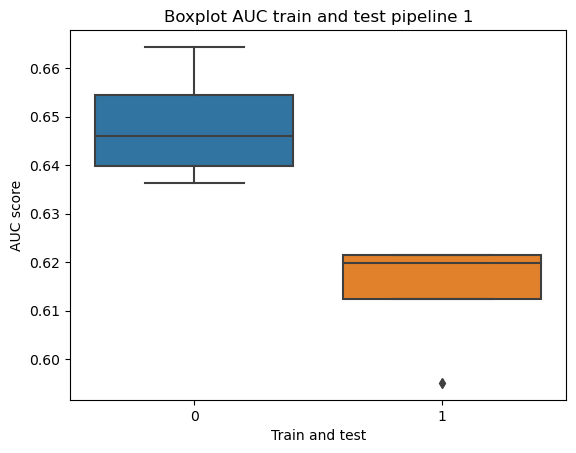

In [13]:
# PIPELINE 1
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

auc_train_1 = []
auc_test_1 = []

best_auc_train_1 = []
best_auc_test_1 = []

results_1 = pd.DataFrame()
best_pipe_1 = []
best_hp_1a = pd.DataFrame()
best_hp_1 = pd.DataFrame()

y_test_1_all = []
y_pred_1_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_1 = y[test_index]
    y_test_1_all.append(y_test_1)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')

    ## PIPELINE 1: RobustScaler --> PCA + univariate --> Gaussian Naive Bayes
    
    # Define pipeline 1
    pipeline_1a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_1a = {
        'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_1a = RandomizedSearchCV(pipeline_1a, param_distributions=param_grid_1a, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search_1a.fit(X_train, y_train) # klopt dit fit_transform?
    X_train = rand_search_1a.best_estimator_.transform(X_train)
    X_test = rand_search_1a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1a = best_hp_1a.append(rand_search_1a.best_params_,ignore_index=True)
    print(best_hp_1a)
    print(f'shape of X_train after pca {X_train.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_train = X_train[:,features_selected]
    X_test = X_test[:,features_selected]
    
    # pipeline 1b
    pipeline_1b = Pipeline([
        ('clf', GaussianNB())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_1b.fit(X_train, y_train)
 
    # print('Training set score before tuning: ' + str(pipeline_1b.score(X_train,y_train)))
    # print('Test set score before tuning: ' + str(pipeline_1b.score(X_test,y_test_1)))

    y_pred_train_1 = pipeline_1b.predict_proba(X_train)[:,1]
    roc_auc_train_1 = roc_auc_score(y_train, y_pred_train_1)

    y_pred_test_1 = pipeline_1b.predict_proba(X_test)[:,1]
    roc_auc_test_1 = roc_auc_score(y_test_1, y_pred_test_1)

    auc_train_1.append(roc_auc_train_1)
    auc_test_1.append(roc_auc_test_1)

    # Define hyperparameters of pipeline 1
    param_grid_1b = {
    'clf__var_smoothing': np.logspace(0,-9, num=100),
    }

    print(f'after feature selection: {X_train.shape}')

    # Perform grid search with inner cross-validation, part 2
    model_1 = RandomizedSearchCV(pipeline_1b, param_distributions=param_grid_1b, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    model_1.fit(X_train, y_train)
    results = pd.DataFrame(model_1.cv_results_)
    results_1 = results_1.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_1 = model_1.predict_proba(X_train)[:,1]
    best_roc_auc_train_1 = roc_auc_score(y_train, best_y_pred_train_1)

    best_y_pred_test_1 = model_1.predict_proba(X_test)[:,1]
    best_roc_auc_test_1 = roc_auc_score(y_test_1, best_y_pred_test_1)

    best_auc_train_1.append(best_roc_auc_train_1)
    best_auc_test_1.append(best_roc_auc_test_1)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_1 = best_hp_1.append(model_1.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_1.append(model_1.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_1}')
print(f'The best pipes per split {best_pipe_1}')

print(f'The training AUCs before tuning {auc_train_1}')
print(f'The test AUCs before tuning {auc_test_1}')

print(f'The training AUCs after tuning {best_auc_train_1}')
print(f'The test AUCs afer tuning {best_auc_test_1}')

data_1 = [best_auc_train_1, best_auc_test_1]
sns.boxplot(data=data_1)
plt.title('Boxplot AUC train and test pipeline 1')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()

### PIPELINE 2
- PCA-Uni --> Quadratic Discriminant Analysis

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
shape of X_train after pca (1020, 8)
size of features selected(5,)
Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
shape of X_train after pca (1022, 6)
size of features selected(5,)
Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


   pca__n_components
0                0.5
1                0.5
2                0.5
shape of X_train after pca (1022, 7)
size of features selected(3,)
Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


   pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
shape of X_train after pca (1022, 7)
size of features selected(2,)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The training AUCs after QDA [0.6789465590157631, 0.6523642296100275, 0.6368465194296897, 0.6243542265846102]
The test AUCs afer QDA [0.6820987654320988, 0.636248012718601, 0.6472178060413355, 0.5696078431372549]


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2757982181.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)


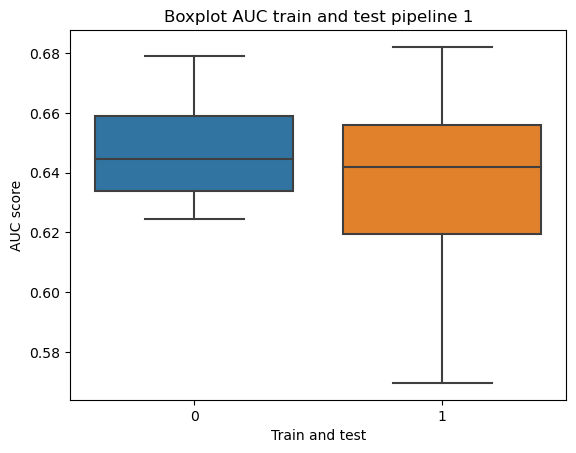

In [14]:
# PIPELINE 2
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_auc_train_2 = []
best_auc_test_2 = []

best_hp_2a = pd.DataFrame()

y_test_2_all = []
y_pred_2_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_2 = y[test_index]
    y_test_2_all.append(y_test_2)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')

    ## PIPELINE 2: QDA
    
    # Define pipeline 2
    pipeline_2a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_2a = {
        'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_2a = RandomizedSearchCV(pipeline_2a, param_distributions=param_grid_2a, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search_2a.fit(X_train, y_train) # klopt dit fit_transform?
    X_train = rand_search_2a.best_estimator_.transform(X_train)
    X_test = rand_search_2a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_2a = best_hp_2a.append(rand_search_2a.best_params_,ignore_index=True)
    print(best_hp_2a)
    print(f'shape of X_train after pca {X_train.shape}')

    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_train = X_train[:,features_selected]
    X_test = X_test[:,features_selected]

    # Train the classifier on the selected features with the best hyperparameters to create best trained classifier
    model_2 = QuadraticDiscriminantAnalysis()
    model_2.fit(X_train, y_train)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_2 = model_2.predict_proba(X_train)[:,1]
    best_roc_auc_train_2 = roc_auc_score(y_train, best_y_pred_train_2)

    best_y_pred_test_2 = model_2.predict_proba(X_test)[:,1]
    best_roc_auc_test_2 = roc_auc_score(y_test_2, best_y_pred_test_2)

    best_auc_train_2.append(best_roc_auc_train_2)
    best_auc_test_2.append(best_roc_auc_test_2)

print(f'The optimal hyperparameters per split: {best_hp_2a}')

print(f'The training AUCs after QDA {best_auc_train_2}')
print(f'The test AUCs afer QDA {best_auc_test_2}')

data_2 = [best_auc_train_2, best_auc_test_2]
sns.boxplot(data=data_2)
plt.title('Boxplot AUC train and test pipeline 1')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 3
- RobustScaler --> PCA + univariate --> SVM_linear

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (1020, 7)
size of features selected(6,)
shape of X_train after univariate: (1020, 6)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(4,)
shape of X_train after univariate: (1022, 4)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(3,)
shape of X_train after univariate: (1022, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(2,)
shape of X_train after univariate: (1022, 2)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:      clf__C
0  0.011288
1  6.158482
2  2.335721
3  6.158482
The best pipes per split [Pipeline(steps=[('clf', SVC(C=0.011288378916846888, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=6.158482110660261, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=2.3357214690901213, kernel='linear'))]), Pipeline(steps=[('clf', SVC(C=6.158482110660261, kernel='linear'))])]
The training AUCs before tuning [0.6923606305267205, 0.6548305191845926, 0.6298421038522372, 0.610215187595023]
The test AUCs before tuning [0.6190708252111761, 0.6413354531001589, 0.6542130365659777, 0.5759803921568627]
The training AUCs after tuning [0.6921914648212226, 0.6559526043481758, 0.6302327273562831, 0.6104756032643869]
Th

C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_3 = results_3.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\2643325771.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)


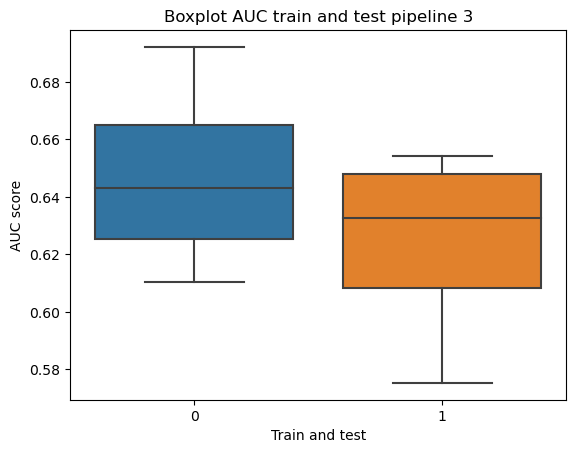

In [15]:
# PIPELINE 3
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_train_3 = []
auc_test_3 = []

best_auc_train_3 = []
best_auc_test_3 = []

results_3 = pd.DataFrame()
best_pipe_3 = []
best_hp_3a = pd.DataFrame()
best_hp_3 = pd.DataFrame()

y_test_3_all = []
y_pred_3_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_3 = y[test_index]
    y_test_3_all.append(y_test_3)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')

    ## PIPELINE 3: RobustScaler --> PCA + univariate --> linear SVM
    
    # Define pipeline 3
    pipeline_3a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_3a = {
        'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_3a = RandomizedSearchCV(pipeline_3a, param_distributions=param_grid_3a, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search_3a.fit(X_train, y_train) # klopt dit fit_transform?
    X_train = rand_search_3a.best_estimator_.transform(X_train)
    X_test = rand_search_3a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3a = best_hp_3a.append(rand_search_3a.best_params_,ignore_index=True)
    print(f'shape of X_train after pca {X_train.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_train = X_train[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_train after univariate: {X_train.shape}')
    
    # pipeline 3b
    pipeline_3b = Pipeline([    
        ('clf', SVC(kernel='linear'))
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_3b.fit(X_train, y_train)
 
    y_pred_train_3 = pipeline_3b.decision_function(X_train)
    roc_auc_train_3 = roc_auc_score(y_train, y_pred_train_3)

    y_pred_test_3 = pipeline_3b.decision_function(X_test)
    roc_auc_test_3 = roc_auc_score(y_test_3, y_pred_test_3)

    auc_train_3.append(roc_auc_train_3)
    auc_test_3.append(roc_auc_test_3)
    
    # Define hyperparameters of pipeline 3
    param_grid_3b = {
    'clf__C': np.logspace(-3, 1, 20),
    }

    # Perform grid search with inner cross-validation, part 1
    model_3 = RandomizedSearchCV(pipeline_3b, param_distributions=param_grid_3b, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    model_3.fit(X_train, y_train)

    results = pd.DataFrame(model_3.cv_results_)
    results_3 = results_3.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_3 = model_3.decision_function(X_train)
    best_roc_auc_train_3 = roc_auc_score(y_train, best_y_pred_train_3)

    best_y_pred_test_3 = model_3.decision_function(X_test)
    best_roc_auc_test_3 = roc_auc_score(y_test_3, best_y_pred_test_3)

    best_auc_train_3.append(best_roc_auc_train_3)
    best_auc_test_3.append(best_roc_auc_test_3)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_3 = best_hp_3.append(model_3.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_3.append(model_3.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_3a}')
print(f'The optimal hyperparameters per split: {best_hp_3}')
print(f'The best pipes per split {best_pipe_3}')

print(f'The training AUCs before tuning {auc_train_3}')
print(f'The test AUCs before tuning {auc_test_3}')

print(f'The training AUCs after tuning {best_auc_train_3}')
print(f'The test AUCs afer tuning {best_auc_test_3}')

data_3 = [best_auc_train_3, best_auc_test_3]
sns.boxplot(data=data_3)
plt.title('Boxplot AUC train and test pipeline 3')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 4
- PCA-UNI --> KNN

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipyker

shape of X_train after pca (1020, 8)
size of features selected(3,)
shape of X_train after univariate: (1020, 3)
Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipyker

shape of X_train after pca (1022, 7)
size of features selected(4,)
shape of X_train after univariate: (1022, 4)
Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipyker

shape of X_train after pca (1022, 6)
size of features selected(3,)
shape of X_train after univariate: (1022, 3)
Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\4264658525.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_4 = results_4.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipyker

shape of X_train after pca (1022, 7)
size of features selected(3,)
shape of X_train after univariate: (1022, 3)
The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       2                 4               2
1       1                 4              12
2       1                 8              12
3       2                 6              19
The best pipes per split [Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=2, n_neighbors=4))]), Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=12, n_neighbors=4, p=1))]), Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=12, n_neighbors=8, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=19, n_neighbors=6))])]
The training AUCs before tuning [0.9670203767781622, 0.9733648385231368, 0.9579218063656312, 0.963763925

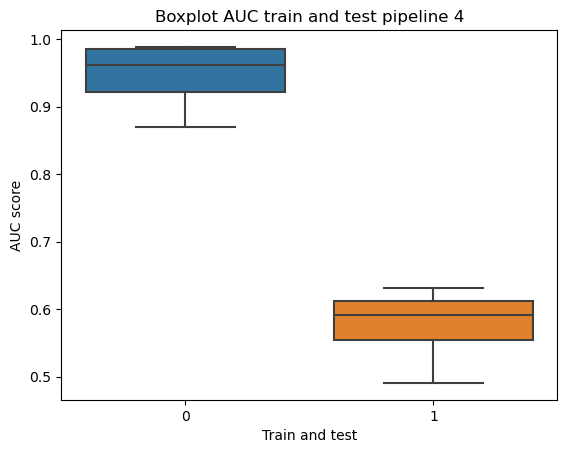

In [16]:
# PIPELINE 4
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_train_4 = []
auc_test_4 = []

best_auc_train_4 = []
best_auc_test_4 = []

results_4 = pd.DataFrame()
best_pipe_4 = []
best_hp_4a = pd.DataFrame()
best_hp_4 = pd.DataFrame()

y_test_4_all = []
y_pred_4_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_4 = y[test_index]
    y_test_4_all.append(y_test_4)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')

    ## PIPELINE 4: RobustScaler --> PCA + univariate --> KNN
    
    # Define pipeline 4a
    pipeline_4a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_4a = {
        'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_4a = RandomizedSearchCV(pipeline_4a, param_distributions=param_grid_4a, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search_4a.fit(X_train, y_train) # klopt dit fit_transform?
    X_train = rand_search_4a.best_estimator_.transform(X_train)
    X_test = rand_search_4a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4a = best_hp_4a.append(rand_search_4a.best_params_,ignore_index=True)
    print(f'shape of X_train after pca {X_train.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_train = X_train[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_train after univariate: {X_train.shape}')
    
    # pipeline 4b
    pipeline_4b = Pipeline([    
        ('clf', KNeighborsClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_4b.fit(X_train, y_train)
 
    y_pred_train_4 = pipeline_4b.predict_proba(X_train)[:,1]
    roc_auc_train_4 = roc_auc_score(y_train, y_pred_train_4)

    y_pred_test_4 = pipeline_4b.predict_proba(X_test)[:,1]
    roc_auc_test_4 = roc_auc_score(y_test_4, y_pred_test_4)

    auc_train_4.append(roc_auc_train_4)
    auc_test_4.append(roc_auc_test_4)
    
    # Define hyperparameters of pipeline 4
    param_grid_4b = {
    'clf__n_neighbors': list(range(4,26,2)), # op 4 begonnen, want uit learning curves bleek dat vanaf 5 goede fit en lager slechte fit
    'clf__p': [1,2],
    'clf__leaf_size': np.arange(1,26,1)
    }

    # Perform grid search with inner cross-validation, part 1
    model_4 = RandomizedSearchCV(pipeline_4b, param_distributions=param_grid_4b, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    model_4.fit(X_train, y_train)

    results = pd.DataFrame(model_4.cv_results_)
    results_4 = results_4.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_4 = model_4.predict_proba(X_train)[:,1]
    best_roc_auc_train_4 = roc_auc_score(y_train, best_y_pred_train_4)

    best_y_pred_test_4 = model_4.predict_proba(X_test)[:,1]
    best_roc_auc_test_4 = roc_auc_score(y_test_4, best_y_pred_test_4)

    best_auc_train_4.append(best_roc_auc_train_4)
    best_auc_test_4.append(best_roc_auc_test_4)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_4 = best_hp_4.append(model_4.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_4.append(model_4.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_4a}')
print(f'The optimal hyperparameters per split: {best_hp_4}')
print(f'The best pipes per split {best_pipe_4}')

print(f'The training AUCs before tuning {auc_train_4}')
print(f'The test AUCs before tuning {auc_test_4}')

print(f'The training AUCs after tuning {best_auc_train_4}')
print(f'The test AUCs afer tuning {best_auc_test_4}')

data_4 = [best_auc_train_4, best_auc_test_4]
sns.boxplot(data=data_4)
plt.title('Boxplot AUC train and test pipeline 4')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()


### PIPELINE 5 
- LASSO --> KNN

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1020, 2928)
This is the size of X_train after LASSO: (1020, 2928)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 924)
This is the size of X_train after LASSO: (1022, 924)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 993)
This is the size of X_train after LASSO: (1022, 993)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)
This is the size of X_train after LASSO: (1022, 506)
This is the size of X_train after LASSO: (1022, 506)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:113: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_5 = results_5.append(results,ignore_index=True)


The optimal hyperparameters per split:    lasso__alpha
0      0.000010
1      0.000129
2      0.000100
3      0.001668
The optimal hyperparameters per split:    clf__p  clf__n_neighbors  clf__leaf_size
0       2                 4              17
1       1                 4               6
2       1                 4              20
3       1                 4               2
The best pipes per split [Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=17, n_neighbors=4))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=6, n_neighbors=4, p=1))]), Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=4, p=1))]), Pipeline(steps=[('clf', KNeighborsClassifier(leaf_size=2, n_neighbors=4, p=1))])]
The training AUCs before tuning [0.9821107266435986, 0.985298003607523, 0.9852520479011646, 0.9819011109792012]
The test AUCs before tuning [0.4599577647823262, 0.6135135135135135, 0.7284578696343402, 0.7312091503267973]
The training AUCs after tuning [0

C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\236455054.py:126: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)


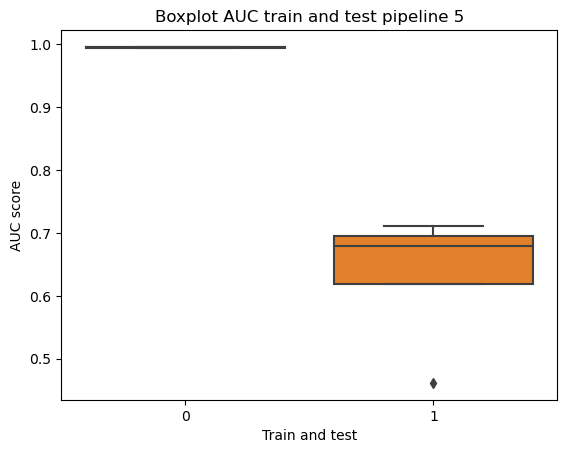

In [17]:
# PIPELINE 5

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_train_5 = []
auc_test_5 = []

best_auc_train_5 = []
best_auc_test_5 = []

results_5 = pd.DataFrame()
best_pipe_5 = []
best_hp_5a = pd.DataFrame()
best_hp_5 = pd.DataFrame()

y_test_5_all = []
y_pred_5_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_5 = y[test_index]
    y_test_5_all.append(y_test_5)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ## PIPELINE 5: RobustScaler --> LASSO --> KNN
    # Define pipeline 5
    pipeline_5a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_5a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_5a = RandomizedSearchCV(pipeline_5a, param_distributions=param_grid_5a, n_iter = 50, cv=inner_cv, scoring='roc_auc',n_jobs=-1) # optimize parameters
    rand_search_5a.fit(X_train, y_train)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_5a.best_params_['lasso__alpha'])
    lasso.fit(X_train, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train = X_train[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_train after LASSO: {X_train.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5a = best_hp_5a.append(rand_search_5a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_train after LASSO: {X_train.shape}')

## PIPELINE 5: RF
    # Define pipeline 5b
    pipeline_5b = Pipeline([
        ('clf', KNeighborsClassifier())
        ])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_5b.fit(X_train, y_train)
 
    y_pred_train_5 = pipeline_5b.predict_proba(X_train)[:,1]
    roc_auc_train_5 = roc_auc_score(y_train, y_pred_train_5)

    y_pred_test_5 = pipeline_5b.predict_proba(X_test)[:,1]
    roc_auc_test_5 = roc_auc_score(y_test_5, y_pred_test_5)

    auc_train_5.append(roc_auc_train_5)
    auc_test_5.append(roc_auc_test_5)

    # Define hyperparameters of pipeline 5b
    param_grid_5b = {'clf__n_neighbors': list(range(4,26,2)),
                  'clf__p': [1,2],
                  'clf__leaf_size': np.arange(1,26,1)
                }

    # Perform grid search with inner cross-validation, part 1
    model_5 = RandomizedSearchCV(pipeline_5b, param_distributions=param_grid_5b, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    model_5.fit(X_train, y_train)

    # Storing results cross-validation
    results = pd.DataFrame(model_5.cv_results_)
    results_5 = results_5.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_5 = model_5.predict_proba(X_train)[:,1]
    best_roc_auc_train_5 = roc_auc_score(y_train, best_y_pred_train_5)

    best_y_pred_test_5 = model_5.predict_proba(X_test)[:,1]
    best_roc_auc_test_5 = roc_auc_score(y_test_5, best_y_pred_test_5)

    best_auc_train_5.append(best_roc_auc_train_5)
    best_auc_test_5.append(best_roc_auc_test_5)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_5 = best_hp_5.append(model_5.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_5.append(model_5.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_5a}')
print(f'The optimal hyperparameters per split: {best_hp_5}')
print(f'The best pipes per split {best_pipe_5}')

print(f'The training AUCs before tuning {auc_train_5}')
print(f'The test AUCs before tuning {auc_test_5}')

print(f'The training AUCs after tuning {best_auc_train_5}')
print(f'The test AUCs afer tuning {best_auc_test_5}')

data_5 = [best_auc_train_5, best_auc_test_5]
sns.boxplot(data=data_5)
plt.title('Boxplot AUC train and test pipeline 5')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()      

### PIPELINE 6
- PCA-UNI --> Random Forest

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (1020, 7)
size of features selected(3,)
shape of X_train after univariate: (1020, 3)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(5,)
shape of X_train after univariate: (1022, 5)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(4,)
shape of X_train after univariate: (1022, 4)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)


shape of X_train after pca (1022, 7)
size of features selected(2,)
shape of X_train after univariate: (1022, 2)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_6 = results_6.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\3532837960.py:129: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)


The optimal hyperparameters per split:    pca__n_components
0                0.5
1                0.5
2                0.5
3                0.5
The optimal hyperparameters per split:    clf__warm_start  clf__n_estimators  clf__min_weight_fraction_leaf  \
0             True                305                       0.083333   
1            False                460                       0.000000   
2            False                105                       0.062500   
3             True                350                       0.062500   

   clf__min_samples_split  clf__min_samples_leaf clf__max_features  \
0                       3                      3              None   
1                       7                      7              sqrt   
2                       5                      6              log2   
3                       3                      9              sqrt   

  clf__criterion  clf__bootstrap  
0       log_loss            True  
1        entropy           False  


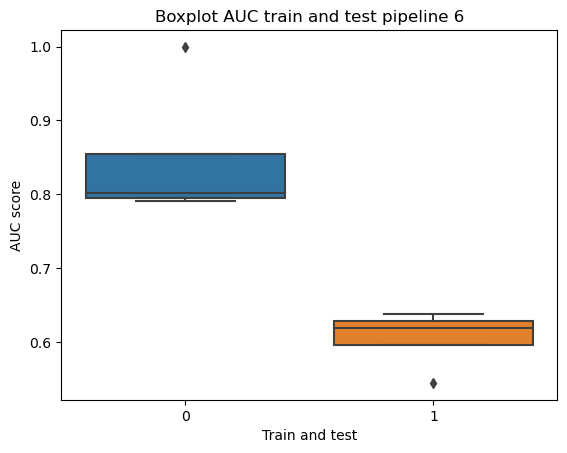

In [18]:
# PIPELINE 6
# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_train_6 = []
auc_test_6 = []

best_auc_train_6 = []
best_auc_test_6 = []

results_6 = pd.DataFrame()
best_pipe_6 = []
best_hp_6a = pd.DataFrame()
best_hp_6 = pd.DataFrame()

y_test_6_all = []
y_pred_6_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_6 = y[test_index]
    y_test_6_all.append(y_test_6)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')

    ## PIPELINE 6: RobustScaler --> PCA + univariate --> RF
    
    # Define pipeline 6a
    pipeline_6a = Pipeline([
        ('scaler', RobustScaler()),
        ('var_threshold', VarianceThreshold(threshold=0.0)),
        ('pca', PCA()),
    ])

    param_grid_6a = {
        'pca__n_components': [0.5,0.75, 0.9, 0.95, 0.99],
        }

    # Perform grid search with inner cross-validation, part 1
    rand_search_6a = RandomizedSearchCV(pipeline_6a, param_distributions=param_grid_6a, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) #klopt n__iter
    rand_search_6a.fit(X_train, y_train)
    X_train = rand_search_6a.best_estimator_.transform(X_train)
    X_test = rand_search_6a.best_estimator_.transform(X_test)
    
    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6a = best_hp_6a.append(rand_search_6a.best_params_,ignore_index=True)
    print(f'shape of X_train after pca {X_train.shape}')

    # univariate feature selection
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(f'size of features selected{features_selected.shape}')
    X_train = X_train[:,features_selected]
    X_test = X_test[:,features_selected]
        
    print(f'shape of X_train after univariate: {X_train.shape}')
    
    # pipeline 6b
    pipeline_6b = Pipeline([    
        ('clf', RandomForestClassifier())
    ])

    # Define scores BEFORE hyperparameter tuning
    pipeline_6b.fit(X_train, y_train)
 
    y_pred_train_6 = pipeline_6b.predict_proba(X_train)[:,1]
    roc_auc_train_6 = roc_auc_score(y_train, y_pred_train_6)

    y_pred_test_6 = pipeline_6b.predict_proba(X_test)[:,1]
    roc_auc_test_6 = roc_auc_score(y_test_6, y_pred_test_6)

    auc_train_6.append(roc_auc_train_6)
    auc_test_6.append(roc_auc_test_6)
    
    # Define hyperparameters of pipeline 6
    param_grid_6b = {'clf__n_estimators' : range(5,1000,5),
                    'clf__criterion' :['gini','entropy','log_loss'],
                    'clf__min_samples_split':range(2,10),
                    'clf__min_samples_leaf':range(1,10),
                    'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                    'clf__max_features':['sqrt','log2',None],
                    'clf__bootstrap':[True,False],
                    'clf__warm_start':[True,False]
                    }

    # Perform grid search with inner cross-validation, part 1
    model_6 = RandomizedSearchCV(pipeline_6b, param_distributions=param_grid_6b, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    model_6.fit(X_train, y_train)

    results = pd.DataFrame(model_6.cv_results_)
    results_6 = results_6.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_6 = model_6.predict_proba(X_train)[:,1]
    best_roc_auc_train_6 = roc_auc_score(y_train, best_y_pred_train_6)

    best_y_pred_test_6 = model_6.predict_proba(X_test)[:,1]
    best_roc_auc_test_6 = roc_auc_score(y_test_6, best_y_pred_test_6)

    best_auc_train_6.append(best_roc_auc_train_6)
    best_auc_test_6.append(best_roc_auc_test_6)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_6 = best_hp_6.append(model_6.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_6.append(model_6.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_6a}')
print(f'The optimal hyperparameters per split: {best_hp_6}')
print(f'The best pipes per split {best_pipe_6}')

print(f'The training AUCs before tuning {auc_train_6}')
print(f'The test AUCs before tuning {auc_test_6}')

print(f'The training AUCs after tuning {best_auc_train_6}')
print(f'The test AUCs afer tuning {best_auc_test_6}')

data_6 = [best_auc_train_6, best_auc_test_6]
sns.boxplot(data=data_6)
plt.title('Boxplot AUC train and test pipeline 6')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()    


### PIPELINE 7
- LASSO --> Random Forest

Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 340852
The total number of outliers in dataset x is 112366
shape after balancing (1020, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 2.550e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1020, 1816)
This is the size of X_train after LASSO: (1020, 1816)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 338980
The total number of outliers in dataset x is 114126
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 1804)
This is the size of X_train after LASSO: (1022, 1804)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (620, 9000)
Size X_test (207, 9000)
The total number of outliers in dataset x is 327066
The total number of outliers in dataset x is 125920
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.541e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.541e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 733)
This is the size of X_train after LASSO: (1022, 733)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


Size_X_train (621, 9000)
Size X_test (206, 9000)
The total number of outliers in dataset x is 349222
The total number of outliers in dataset x is 104432
shape after balancing (1022, 9000)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.271e-02, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.271e-02, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)


This is the size of X_train after LASSO: (1022, 537)
This is the size of X_train after LASSO: (1022, 537)


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_7 = results_7.append(results,ignore_index=True)
C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1368562180.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)


The optimal hyperparameters per split:    lasso__alpha
0      0.000028
1      0.000028
2      0.000278
3      0.001292
The optimal hyperparameters per split:    clf__warm_start  clf__n_estimators  clf__min_weight_fraction_leaf  \
0            False                 95                       0.020833   
1             True                830                       0.000000   
2             True                695                       0.020833   
3            False                555                       0.041667   

   clf__min_samples_split  clf__min_samples_leaf clf__max_features  \
0                       4                      6              None   
1                       8                      4              sqrt   
2                       9                      6              sqrt   
3                       2                      8              log2   

  clf__criterion  clf__bootstrap  
0        entropy            True  
1       log_loss           False  
2        entropy         

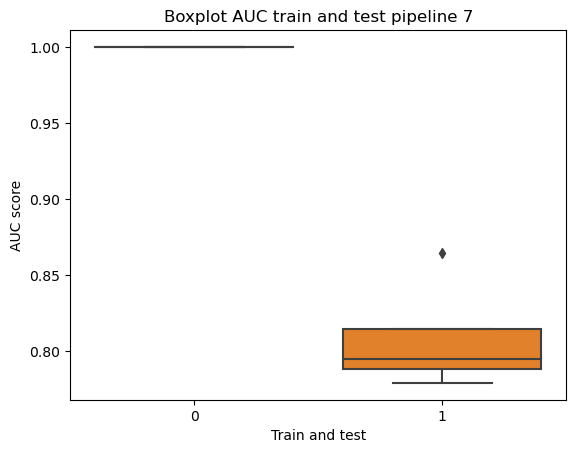

In [19]:
# PIPELINE 7

# Define outer and inner cross validation
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # to do: in discussie zetten waarom loopen nog beter zou zijn voor generaliseren
inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_train_7 = []
auc_test_7 = []

best_auc_train_7 = []
best_auc_test_7 = []

results_7 = pd.DataFrame()
best_pipe_7 = []
best_hp_7a = pd.DataFrame()
best_hp_7 = pd.DataFrame()

y_test_7_all = []
y_pred_7_all = []

for train_index, test_index in outer_cv.split(X, y): 
    X_train = X.transpose()[train_index]
    X_train = X_train.transpose()
    print(f'Size_X_train {X_train.shape}') # print size of X_train
    y_train = y[train_index]
    
    X_test = X.transpose()[test_index]
    X_test = X_test.transpose()
    y_test_7 = y[test_index]
    y_test_7_all.append(y_test_7)
    print(f'Size X_test {X_test.shape}')     # print size of X_test
    
    # correct for missing data
    # X_train = missing_data(X_train)
    # X_test = missing_data(X_test)
    # remove outliers
    X_train = removing_outliers(X_train)
    X_test = removing_outliers(X_test)

    # balance the classes, so training set consists of 50% normal and 50% abnormal ECG's
    ros = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    X_train = X_resampled
    y_train = y_resampled   

    print(f'shape after balancing {X_train.shape}')  

    # Scaling the data
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ## PIPELINE 7: RobustScaler --> LASSO --> RF
    # Define pipeline 7
    pipeline_7a = Pipeline([
        ('lasso', Lasso()),
    ])
    # Define hyperparameters of pipeline 5
    param_grid_7a = {
    'lasso__alpha': np.logspace(-10, 1, 100),
    }

    # Perform randomized search with inner cross-validation to find best alpha
    rand_search_7a = RandomizedSearchCV(pipeline_7a, param_distributions=param_grid_7a, n_iter = 50, cv=inner_cv, scoring='roc_auc',n_jobs=-1) # optimize parameters
    rand_search_7a.fit(X_train, y_train)
    
    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=rand_search_7a.best_params_['lasso__alpha'])
    lasso.fit(X_train, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train = X_train[:, selected_features]
    X_test = X_test[:, selected_features]
    print(f'This is the size of X_train after LASSO: {X_train.shape}')

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7a = best_hp_7a.append(rand_search_7a.best_params_,ignore_index=True)
    
    print(f'This is the size of X_train after LASSO: {X_train.shape}')

## PIPELINE 7: RF
    # Define pipeline 7b
    pipeline_7b = Pipeline([
        ('clf', RandomForestClassifier())])
    
    # Define scores BEFORE hyperparameter tuning
    pipeline_7b.fit(X_train, y_train)
 
    y_pred_train_7 = pipeline_7b.predict_proba(X_train)[:,1]
    roc_auc_train_7 = roc_auc_score(y_train, y_pred_train_7)

    y_pred_test_7 = pipeline_7b.predict_proba(X_test)[:,1]
    roc_auc_test_7 = roc_auc_score(y_test_7, y_pred_test_7)

    auc_train_7.append(roc_auc_train_7)
    auc_test_7.append(roc_auc_test_7)

    # Define hyperparameters of pipeline 7b
    param_grid_7b = {'clf__n_estimators' : range(5,1000,5),
                               'clf__criterion' :['gini','entropy','log_loss'],
                               'clf__min_samples_split':range(2,10),
                               'clf__min_samples_leaf':range(1,10),
                               'clf__min_weight_fraction_leaf' : np.linspace(0, 0.5, 25),
                               'clf__max_features':['sqrt','log2',None],
                               'clf__bootstrap':[True,False],
                               'clf__warm_start':[True,False],
                               }

    # Perform grid search with inner cross-validation, part 1
    model_7 = RandomizedSearchCV(pipeline_7b, param_distributions=param_grid_7b, n_iter=50, cv=inner_cv, scoring='roc_auc', n_jobs=-1) # optimize parameters
    model_7.fit(X_train, y_train)

    # Storing results cross-validation
    results = pd.DataFrame(model_7.cv_results_)
    results_7 = results_7.append(results,ignore_index=True)

    # Define scores AFTER hyperparameter tuning 
    best_y_pred_train_7 = model_7.predict_proba(X_train)[:,1]
    best_roc_auc_train_7 = roc_auc_score(y_train, best_y_pred_train_7)

    best_y_pred_test_7 = model_7.predict_proba(X_test)[:,1]
    best_roc_auc_test_7 = roc_auc_score(y_test_7, best_y_pred_test_7)

    best_auc_train_7.append(best_roc_auc_train_7)
    best_auc_test_7.append(best_roc_auc_test_7)

    # Access and store the best set of hyperparameters of each outer-CV loop in a DataFrame
    best_hp_7 = best_hp_7.append(model_7.best_params_,ignore_index=True)
    # Stores the optimum model in best_pipe
    best_pipe_7.append(model_7.best_estimator_)

print(f'The optimal hyperparameters per split: {best_hp_7a}')
print(f'The optimal hyperparameters per split: {best_hp_7}')
print(f'The best pipes per split {best_pipe_7}')

print(f'The training AUCs before tuning {auc_train_7}')
print(f'The test AUCs before tuning {auc_test_7}')

print(f'The training AUCs after tuning {best_auc_train_7}')
print(f'The test AUCs afer tuning {best_auc_test_7}')

data_7 = [best_auc_train_7, best_auc_test_7]
sns.boxplot(data=data_7)
plt.title('Boxplot AUC train and test pipeline 7')
plt.xlabel('Train and test')
plt.ylabel('AUC score')
plt.show()   


## Tabellen results

In [22]:
results_1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002194,0.000599,0.002892,0.000537,0.0,{'clf__var_smoothing': 4.3287612810830526e-08},0.548635,0.651672,0.723568,0.640907,0.736255,0.576317,0.612457,0.659362,0.709727,0.667820,0.652672,0.058269,29
1,0.002395,0.000490,0.002892,0.000537,0.000187,{'clf__var_smoothing': 0.0001873817422860383},0.548635,0.651672,0.723568,0.640907,0.736255,0.576701,0.612841,0.659362,0.709727,0.667820,0.652749,0.058192,18
2,0.002094,0.000537,0.002892,0.000537,0.0,{'clf__var_smoothing': 1.873817422860383e-07},0.548635,0.651672,0.723568,0.640907,0.736255,0.576317,0.612457,0.659362,0.709727,0.667820,0.652672,0.058269,29
3,0.002394,0.000914,0.002792,0.000747,0.002848,{'clf__var_smoothing': 0.002848035868435802},0.549789,0.651672,0.723568,0.641292,0.736640,0.576701,0.612841,0.659362,0.709727,0.668205,0.652980,0.058044,10
4,0.002094,0.000299,0.002493,0.000499,0.811131,{'clf__var_smoothing': 0.8111308307896871},0.564014,0.670127,0.690504,0.633218,0.721646,0.599000,0.609765,0.666282,0.658208,0.668973,0.648174,0.044422,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.001758,0.000678,0.002321,0.000830,0.004329,{'clf__var_smoothing': 0.004328761281083057},0.701735,0.581448,0.628220,0.681276,0.556324,0.631680,0.662053,0.621300,0.569012,0.670127,0.630317,0.046902,48
196,0.002018,0.000658,0.002739,0.000690,0.0,{'clf__var_smoothing': 1e-09},0.701357,0.582202,0.627835,0.680892,0.556709,0.632449,0.660515,0.622453,0.569012,0.670127,0.630355,0.046546,15
197,0.002907,0.000557,0.003004,0.000452,0.0,{'clf__var_smoothing': 4.3287612810830526e-08},0.701357,0.582202,0.627835,0.680892,0.556709,0.632449,0.660515,0.622453,0.569012,0.670127,0.630355,0.046546,15
198,0.002094,0.000300,0.002095,0.000537,0.000019,{'clf__var_smoothing': 1.873817422860383e-05},0.701357,0.582202,0.627835,0.680892,0.556709,0.632449,0.660515,0.622453,0.569012,0.670127,0.630355,0.046546,15


In [23]:
results_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,16.656611,3.518039,0.009890,0.006385,2.335721,{'clf__C': 2.3357214690901213},0.678201,0.694733,0.662053,0.715879,0.674356,0.732026,0.675509,0.703191,0.661284,0.663975,0.686121,0.023149,2
1,0.160107,0.026645,0.007481,0.000920,0.011288,{'clf__C': 0.011288378916846888},0.677816,0.693579,0.663591,0.716647,0.674740,0.730488,0.676663,0.702422,0.662438,0.663206,0.686159,0.022590,1
2,0.070373,0.011194,0.009868,0.003653,0.001,{'clf__C': 0.001},0.675509,0.692810,0.662438,0.717416,0.673972,0.730488,0.676663,0.704344,0.662053,0.663206,0.685890,0.023106,4
3,9.856682,3.456652,0.007977,0.006304,1.43845,{'clf__C': 1.438449888287663},0.677432,0.693579,0.662053,0.716647,0.674740,0.731642,0.676278,0.703191,0.660900,0.662053,0.685852,0.023338,5
4,0.622443,0.188986,0.009518,0.007936,0.078476,{'clf__C': 0.07847599703514611},0.677432,0.694348,0.661669,0.716647,0.674740,0.730104,0.676663,0.702422,0.662438,0.662053,0.685852,0.022873,5
5,22.302679,6.978673,0.009237,0.005840,3.79269,{'clf__C': 3.792690190732246},0.676278,0.693964,0.662822,0.715494,0.674740,0.732411,0.675125,0.702807,0.662053,0.662822,0.685852,0.023145,5
6,51.070184,11.089042,0.007480,0.006805,10.0,{'clf__C': 10.0},0.675894,0.690888,0.663975,0.713956,0.676278,0.733564,0.675125,0.703576,0.663591,0.663975,0.686082,0.022724,3
7,36.305792,8.418938,0.005191,0.004477,6.158482,{'clf__C': 6.158482110660261},0.675509,0.693579,0.663591,0.712803,0.674740,0.732026,0.674356,0.703576,0.663206,0.663975,0.685736,0.022543,10
8,0.085714,0.003763,0.012006,0.007978,0.002637,{'clf__C': 0.0026366508987303583},0.675509,0.693964,0.662822,0.716647,0.674740,0.730104,0.676663,0.702422,0.662053,0.663206,0.685813,0.022741,9
9,0.096498,0.019164,0.005405,0.007619,0.001624,{'clf__C': 0.001623776739188721},0.675509,0.693579,0.662822,0.716647,0.673972,0.730488,0.676663,0.703576,0.662053,0.663206,0.685852,0.022928,5


In [24]:
results_4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__p,param_clf__n_neighbors,param_clf__leaf_size,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003291,1.003085e-03,0.004189,0.000977,2,4,2,"{'clf__p': 2, 'clf__n_neighbors': 4, 'clf__lea...",0.851980,0.874471,...,0.890427,0.888120,0.821607,0.853326,0.908112,0.883506,0.851980,0.870377,0.024028,1
1,0.002989,6.361229e-04,0.004488,0.000669,1,18,12,"{'clf__p': 1, 'clf__n_neighbors': 18, 'clf__le...",0.689542,0.755094,...,0.747597,0.789120,0.709343,0.736640,0.824106,0.763745,0.653979,0.743022,0.046459,7
2,0.002194,3.989941e-04,0.004388,0.000489,2,20,9,"{'clf__p': 2, 'clf__n_neighbors': 20, 'clf__le...",0.715494,0.761053,...,0.738178,0.744329,0.737024,0.783929,0.782776,0.771626,0.644560,0.742388,0.038614,8
3,0.002294,4.571271e-04,0.004488,0.000669,2,24,8,"{'clf__p': 2, 'clf__n_neighbors': 24, 'clf__le...",0.723376,0.756632,...,0.729527,0.763168,0.695117,0.781238,0.761053,0.772203,0.654940,0.738850,0.037072,10
4,0.001995,5.545475e-07,0.005884,0.001967,1,24,19,"{'clf__p': 1, 'clf__n_neighbors': 24, 'clf__le...",0.715494,0.749135,...,0.761630,0.775087,0.694156,0.735871,0.801999,0.752018,0.658208,0.740465,0.039523,9
5,0.002194,5.996626e-04,0.003792,0.000864,2,8,8,"{'clf__p': 2, 'clf__n_neighbors': 8, 'clf__lea...",0.773164,0.851019,...,0.785467,0.803537,0.750865,0.783353,0.858324,0.836409,0.782199,0.802095,0.033541,2
6,0.002493,4.989151e-04,0.004189,0.000399,1,12,24,"{'clf__p': 1, 'clf__n_neighbors': 12, 'clf__le...",0.721453,0.803153,...,0.784698,0.772203,0.716455,0.758939,0.807382,0.770665,0.676278,0.753864,0.040072,4
7,0.002992,6.303366e-04,0.004987,0.000892,2,12,6,"{'clf__p': 2, 'clf__n_neighbors': 12, 'clf__le...",0.767013,0.800077,...,0.790850,0.783545,0.734717,0.773356,0.808343,0.792195,0.731642,0.772165,0.026610,3
8,0.002793,3.993526e-04,0.004288,0.000457,1,12,6,"{'clf__p': 1, 'clf__n_neighbors': 12, 'clf__le...",0.721453,0.803153,...,0.784698,0.772203,0.716455,0.758939,0.807382,0.770665,0.676278,0.753864,0.040072,4
9,0.002692,4.570233e-04,0.004189,0.000598,1,12,5,"{'clf__p': 1, 'clf__n_neighbors': 12, 'clf__le...",0.721453,0.803153,...,0.784698,0.772203,0.716455,0.758939,0.807382,0.770665,0.676278,0.753864,0.040072,4


In [25]:
results_5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__p,param_clf__n_neighbors,param_clf__leaf_size,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.138231,0.028712,0.317403,0.036575,2,8,1,"{'clf__p': 2, 'clf__n_neighbors': 8, 'clf__lea...",0.888312,0.853133,...,0.862937,0.896578,0.891388,0.876970,0.890811,0.869473,0.876586,0.882238,0.017304,13
1,0.143643,0.035866,2.155277,0.293942,1,22,2,"{'clf__p': 1, 'clf__n_neighbors': 22, 'clf__le...",0.763552,0.773549,...,0.770281,0.840062,0.808343,0.782968,0.848904,0.839869,0.890042,0.813687,0.039324,41
2,0.172482,0.081114,1.925199,0.266354,1,10,11,"{'clf__p': 1, 'clf__n_neighbors': 10, 'clf__le...",0.845252,0.804883,...,0.844867,0.891003,0.842753,0.841984,0.926951,0.876586,0.868512,0.864917,0.034362,19
3,0.132689,0.028150,1.827928,0.265455,1,10,5,"{'clf__p': 1, 'clf__n_neighbors': 10, 'clf__le...",0.845252,0.804883,...,0.844867,0.891003,0.842753,0.841984,0.926951,0.876586,0.868512,0.864917,0.034362,19
4,0.121682,0.033995,0.125087,0.011758,2,4,17,"{'clf__p': 2, 'clf__n_neighbors': 4, 'clf__lea...",0.929066,0.867743,...,0.941369,0.908881,0.907151,0.912534,0.970204,0.908112,0.935986,0.924337,0.028521,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.009350,0.008908,0.075835,0.012012,2,18,13,"{'clf__p': 2, 'clf__n_neighbors': 18, 'clf__le...",0.887255,0.891780,...,0.877739,0.834487,0.862361,0.835063,0.861015,0.829296,0.883122,0.860122,0.022936,45
196,0.014097,0.008248,0.151880,0.013532,1,8,18,"{'clf__p': 1, 'clf__n_neighbors': 8, 'clf__lea...",0.945324,0.891214,...,0.923875,0.877355,0.922722,0.878124,0.935409,0.887735,0.892157,0.901128,0.027350,4
197,0.021081,0.008699,0.065206,0.004067,2,24,4,"{'clf__p': 2, 'clf__n_neighbors': 24, 'clf__le...",0.929676,0.885181,...,0.901769,0.799692,0.891388,0.855056,0.857363,0.803153,0.877932,0.860840,0.042687,43
198,0.012108,0.008139,0.149870,0.007800,1,24,18,"{'clf__p': 1, 'clf__n_neighbors': 24, 'clf__le...",0.883484,0.921380,...,0.871780,0.799692,0.883891,0.825836,0.856594,0.858708,0.918301,0.866242,0.036267,32


In [26]:
results_6

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__warm_start,param_clf__n_estimators,param_clf__min_weight_fraction_leaf,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.292999,0.048160,0.170793,0.008375,False,825,0.208333,8,7,sqrt,...,0.660131,0.641292,0.698577,0.609765,0.714148,0.715879,0.569589,0.670377,0.049402,3
1,1.753963,0.024495,0.097557,0.005639,False,490,0.395833,2,4,None,...,0.623991,0.588043,0.651672,0.578431,0.682622,0.700115,0.562476,0.640792,0.051477,8
2,2.534142,0.053416,0.148749,0.009113,True,760,0.395833,9,6,log2,...,0.635717,0.609573,0.707036,0.596309,0.708958,0.711457,0.571511,0.661399,0.051994,7
3,1.539101,0.043512,0.060679,0.006590,True,305,0.083333,3,3,None,...,0.780085,0.720877,0.731642,0.740100,0.766244,0.850827,0.684352,0.754248,0.042913,1
4,1.593996,0.023522,0.123013,0.005947,True,620,0.333333,6,6,log2,...,0.633410,0.622837,0.719531,0.595348,0.715110,0.714341,0.579393,0.664687,0.051580,6
5,1.483540,0.024036,0.103742,0.005293,True,520,0.479167,2,8,None,...,0.529412,0.529412,0.637255,0.519608,0.588235,0.637255,0.529412,0.582353,0.047263,9
6,2.453231,0.026769,0.170428,0.007378,False,890,0.229167,9,4,log2,...,0.648981,0.636486,0.678777,0.600730,0.699731,0.703191,0.606113,0.670069,0.044037,4
7,1.380891,0.020258,0.069891,0.004564,False,345,0.208333,9,6,None,...,0.653018,0.598808,0.732987,0.625144,0.712034,0.719723,0.594387,0.668973,0.049089,5
8,2.633617,0.030449,0.182927,0.008476,False,940,0.479167,7,3,None,...,0.529412,0.529412,0.637255,0.519608,0.588235,0.637255,0.529412,0.582353,0.047263,9
9,1.965075,0.231650,0.098434,0.020891,True,870,0.229167,5,6,log2,...,0.650135,0.644944,0.676471,0.596501,0.705498,0.703576,0.608420,0.670800,0.043158,2


In [27]:
results_7

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__warm_start,param_clf__n_estimators,param_clf__min_weight_fraction_leaf,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1366.429650,9.478976,0.240743,0.016387,True,875,0.020833,8,1,None,...,0.996540,0.988850,0.997309,0.991542,0.998847,1.000000,0.998462,0.995002,0.005007,2
1,25.157413,0.666098,0.132654,0.012276,False,560,0.020833,8,5,sqrt,...,0.998462,0.982314,0.998462,0.991157,0.998462,1.000000,0.998462,0.994348,0.006826,3
2,6.617598,0.102281,0.103876,0.007576,True,485,0.229167,5,7,sqrt,...,0.911188,0.907343,0.866590,0.909266,0.913879,0.944637,0.821607,0.891273,0.038914,25
3,23.598709,0.554911,0.157283,0.059867,False,665,0.041667,4,7,sqrt,...,0.987697,0.975779,0.991542,0.991157,0.995771,0.998847,0.985390,0.988658,0.007146,4
4,1.876386,0.263413,0.068479,0.018053,False,245,0.229167,6,6,log2,...,0.883122,0.884660,0.881584,0.919262,0.930796,0.960015,0.805075,0.888735,0.047476,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,25.775373,0.457079,0.022912,0.006672,True,105,0.104167,3,1,None,...,0.948481,0.894271,0.907343,0.937716,0.948866,0.935025,0.957709,0.918653,0.034003,19
196,17.584202,0.405176,0.032366,0.008926,True,145,0.291667,9,6,None,...,0.898501,0.806997,0.740484,0.875048,0.922722,0.846790,0.894656,0.832054,0.065456,39
197,2.055622,0.059215,0.072711,0.007068,False,400,0.208333,3,2,log2,...,0.972703,0.948097,0.975010,0.945021,0.973856,0.910419,0.955017,0.950526,0.019810,13
198,4.253547,0.083552,0.111609,0.009605,False,555,0.041667,2,8,log2,...,0.999616,0.994233,0.999616,0.999616,1.000000,0.989235,0.987697,0.995675,0.004291,1


## Ouput visualization
- Tabel ROC/AUC
- Plot ROC/AUC
- Confusion matrix
- Tabel chosen hyperparameters

In [20]:
# Tabel ROC-AUC
from IPython.display import HTML

# create the DataFrame
df = pd.DataFrame({
    'Pipeline 1': best_auc_test_1,
    'Pipeline 2': best_auc_test_2,
    'Pipeline 3': best_auc_test_3,
    'Pipeline 4': best_auc_test_4,
    'Pipeline 5': best_auc_test_5,
    'Pipeline 6': best_auc_test_6,
    'Pipeline 7': best_auc_test_7
})

# define a function to format the table
def format_table(df):
    return df.style.set_table_styles([{
        'selector': 'th',
        'props': [
            ('font-size', '14pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }, {
        'selector': 'td',
        'props': [
            ('font-size', '12pt'),
            ('text-align', 'center'),
            ('border', '1px solid #ddd'),
            ('padding', '8px')
        ]
    }])

# display the DataFrame as a table
print('Table ROC-AUC')
HTML(format_table(df).render())

Table ROC-AUC


C:\Users\irisv\AppData\Local\Temp\ipykernel_3528\1236091358.py:37: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  HTML(format_table(df).render())


,Pipeline 1,Pipeline 2,Pipeline 3,Pipeline 4,Pipeline 5,Pipeline 6,Pipeline 7
0,0.621507,0.682099,0.619396,0.490497,0.461420,0.544428,0.791423
1,0.621463,0.636248,0.645946,0.576153,0.670588,0.637361,0.864388
2,0.618283,0.647218,0.654372,0.606280,0.689348,0.613514,0.798410
3,0.595098,0.569608,0.575327,0.631618,0.711029,0.625327,0.779248


In [37]:
print(len(y_pred_test_3))
print(len(y_test_3))
print(len(y_test_3_all))

206
206
4


[] y pred 1
[1      1
3      0
5      0
17     0
21     0
      ..
818    0
820    0
821    0
822    0
825    0
Name: label, Length: 207, dtype: int64, 2      0
4      0
7      0
8      0
9      0
      ..
802    0
807    0
815    0
816    0
823    0
Name: label, Length: 207, dtype: int64, 6      0
16     0
18     1
25     0
27     0
      ..
806    0
812    0
814    0
817    0
824    0
Name: label, Length: 207, dtype: int64, 0      0
10     0
11     0
12     1
15     1
      ..
795    0
808    0
810    0
819    0
826    1
Name: label, Length: 206, dtype: int64] y test 1


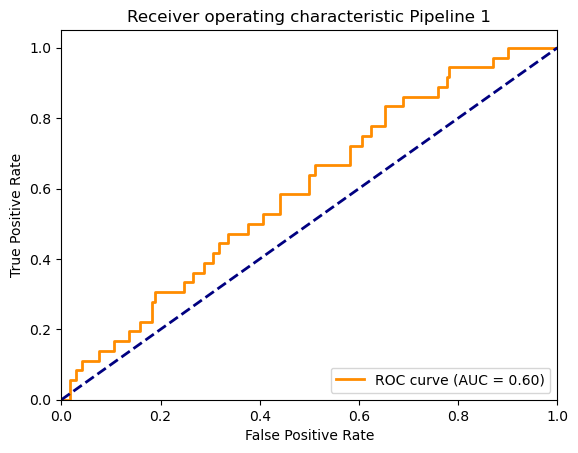

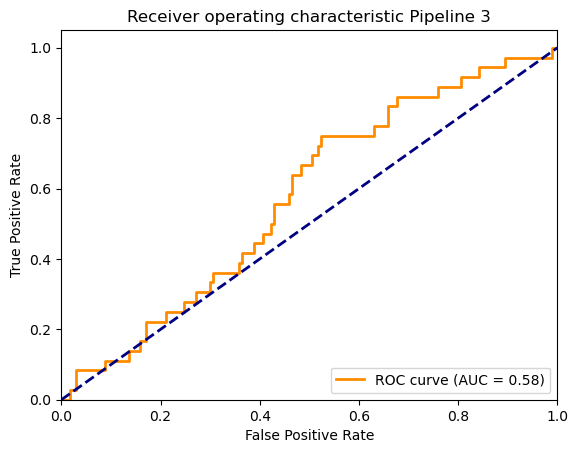

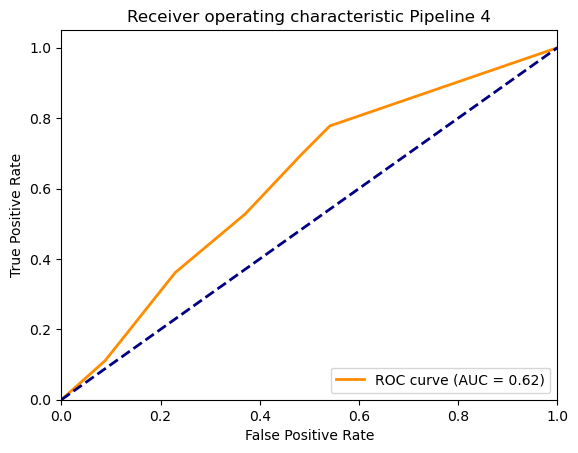

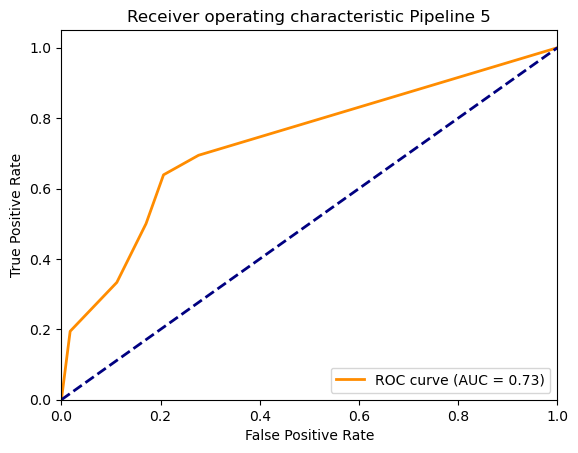

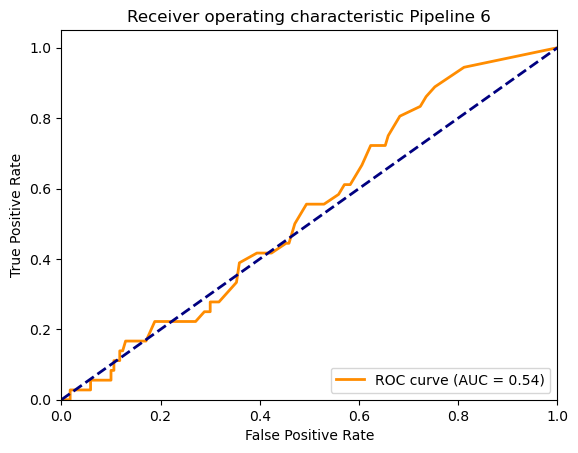

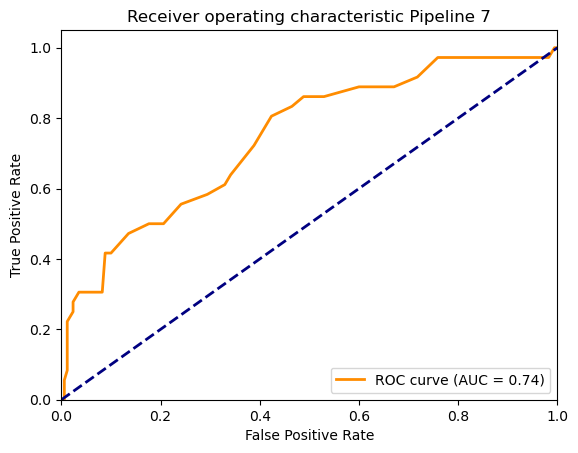

In [39]:
# Plot ROC-AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
print(y_pred_1_all, 'y pred 1')
print(y_test_1_all, 'y test 1')



# y_test contains the true labels, y_pred contains the predicted scores
fpr1, tpr1, thresholds = roc_curve(y_test_1, y_pred_test_1)

# Calculate the area under the curve (AUC)
roc_auc_1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 1')
plt.legend(loc="lower right")
plt.show()

# # y_test contains the true labels, y_pred contains the predicted scores
# fpr2, tpr2, thresholds = roc_curve(y_test_2, y_pred_test_2)

# # Calculate the area under the curve (AUC)
# roc_auc_2 = auc(fpr2, tpr2)

# # Plot the ROC curve
# plt.figure()
# plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_2)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic Pipeline 2')
# plt.legend(loc="lower right")
# plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr3, tpr3, thresholds = roc_curve(y_test_3, y_pred_test_3)

# Calculate the area under the curve (AUC)
roc_auc_3 = auc(fpr3, tpr3)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 3')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr4, tpr4, thresholds = roc_curve(y_test_4, y_pred_test_4)

# Calculate the area under the curve (AUC)
roc_auc_4 = auc(fpr4, tpr4)

# Plot the ROC curve
plt.figure()
plt.plot(fpr4, tpr4, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 4')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr5, tpr5, thresholds = roc_curve(y_test_5, y_pred_test_5)

# Calculate the area under the curve (AUC)
roc_auc_5 = auc(fpr5, tpr5)

# Plot the ROC curve
plt.figure()
plt.plot(fpr5, tpr5, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 5')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr6, tpr6, thresholds = roc_curve(y_test_6, y_pred_test_6)

# Calculate the area under the curve (AUC)
roc_auc_6 = auc(fpr6, tpr6)

# Plot the ROC curve
plt.figure()
plt.plot(fpr6, tpr6, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_6)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 6')
plt.legend(loc="lower right")
plt.show()

# y_test contains the true labels, y_pred contains the predicted scores
fpr7, tpr7, thresholds = roc_curve(y_test_7, y_pred_test_7)

# Calculate the area under the curve (AUC)
roc_auc_7 = auc(fpr7, tpr7)

# Plot the ROC curve
plt.figure()
plt.plot(fpr7, tpr7, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Pipeline 7')
plt.legend(loc="lower right")
plt.show()

In [41]:
print(y_test_1)

0      0
10     0
11     0
12     1
15     1
      ..
795    0
808    0
810    0
819    0
826    1
Name: label, Length: 206, dtype: int64


In [43]:
print(y_pred_test_1.shape)

(206,)


In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# y_test contains the true labels, y_pred contains the predicted labels
cm1 = confusion_matrix(y_test_1, y_pred_test_1)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 1')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm2 = confusion_matrix(y_test_2, y_pred_test_2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 2')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm3 = confusion_matrix(y_test_3, y_pred_test_3)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 3')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm4 = confusion_matrix(y_test_4, y_pred_test_4)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm4, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 4')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm5 = confusion_matrix(y_test_5, y_pred_test_5)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm5, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 5')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm6 = confusion_matrix(y_test_6, y_pred_test_6)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm6, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 6')
plt.show()

# y_test contains the true labels, y_pred contains the predicted labels
cm7 = confusion_matrix(y_test_7, y_pred_test_7)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm7, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix Pipeline 7')
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

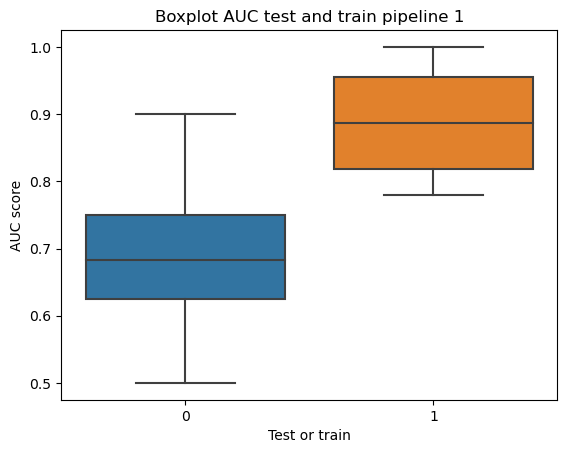

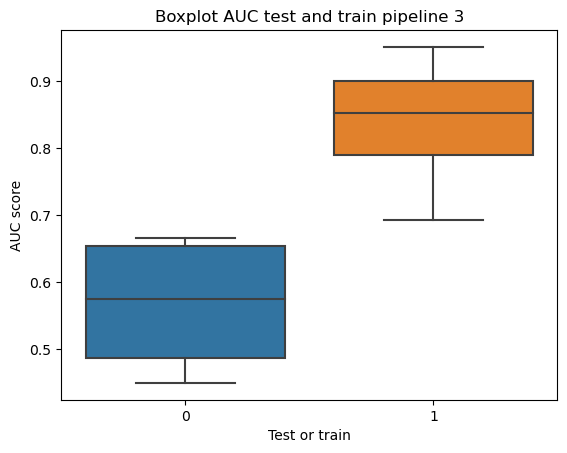

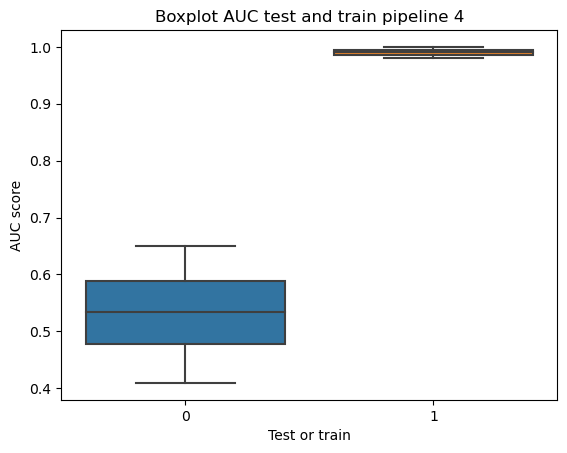

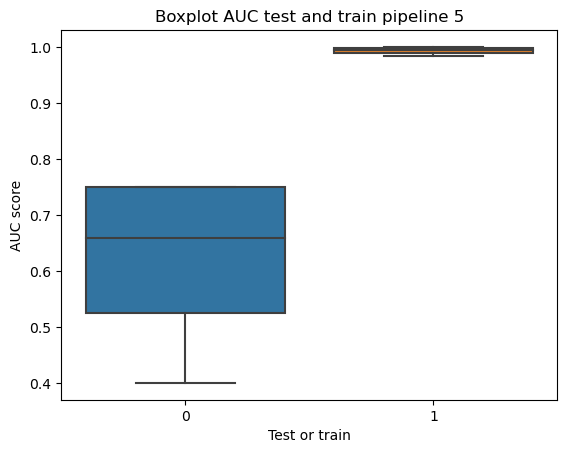

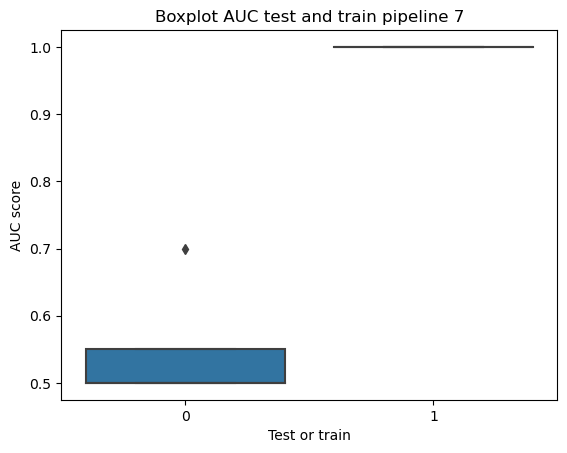

In [ ]:
# Boxplots
data_1 = [best_auc_test_1, best_auc_train_1]
sns.boxplot(data=data_1)
plt.title('Boxplot AUC test and train pipeline 1')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_2 = [best_auc_test_2, best_auc_train_2]
sns.boxplot(data=data_2)
plt.title('Boxplot AUC test and train pipeline 2')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_3 = [best_auc_test_3, best_auc_train_3]
sns.boxplot(data=data_3)
plt.title('Boxplot AUC test and train pipeline 3')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_4 = [best_auc_test_4, best_auc_train_4]
sns.boxplot(data=data_4)
plt.title('Boxplot AUC test and train pipeline 4')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_5 = [best_auc_test_5, best_auc_train_5]
sns.boxplot(data=data_5)
plt.title('Boxplot AUC test and train pipeline 5')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_6 = [best_auc_test_6, best_auc_train_6]
sns.boxplot(data=data_6)
plt.title('Boxplot AUC test and train pipeline 6')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()
data_7 = [best_auc_test_7, best_auc_train_7]
sns.boxplot(data=data_7)
plt.title('Boxplot AUC test and train pipeline 7')
plt.xlabel('Test or train')
plt.ylabel('AUC score')
plt.show()


In [ ]:
# # Tabel hyperparameter chosen one
# # Tabel ROC-AUC
# from IPython.display import HTML

# # Hierboven hyperparameters van de gekozen invullen
# df = pd.DataFrame({'Hyperparameter 1': best_hp_1                   
# })

# # define a function to format the table
# def format_table(df):
#     return df.style.set_table_styles([{
#         'selector': 'th',
#         'props': [
#             ('font-size', '14pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }, {
#         'selector': 'td',
#         'props': [
#             ('font-size', '12pt'),
#             ('text-align', 'center'),
#             ('border', '1px solid #ddd'),
#             ('padding', '8px')
#         ]
#     }])

# # display the DataFrame as a table
# print('Table Hyperparameters')
# HTML(format_table(df).render())